# Task 2 CNN

## Load data/augment

In [1]:
import torch
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import datasets, transforms
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import cv2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

transform_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)), # for transfer learning
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
transform_test = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)), # for transfer learning
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

dataset = datasets.ImageFolder(root="Data")

total_size = len(dataset)
train_size = int(0.70 * total_size) # 70/15/15 split
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_subset, val_subset, test_subset = random_split(
    dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

# Custom class for applying different augmentations to sets

class TransformWrapper(Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        img, label = self.subset[index]
        return self.transform(img), label

    def __len__(self):
        return len(self.subset)


train_subset = TransformWrapper(train_subset, transform_train)
test_subset = TransformWrapper(test_subset,  transform_test)
val_subset = TransformWrapper(val_subset,  transform_test)

train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=0)
test_loader  = DataLoader(test_subset,  batch_size=32, shuffle=False, num_workers=0)
val_loader   = DataLoader(val_subset,   batch_size=32, shuffle=False, num_workers=0)



Using device: cuda


In [2]:
import torch
from torch import nn
from torch.optim import Adam
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

def train_model(model, train_loader, val_loader, optimizer, criterion, epochs=20, patience=5, device="cpu"):

    model.to(device)

    best_val_loss = np.inf
    epochs_no_improve = 0
    val_loss_history = []

    for epoch in range(epochs):
        model.train()

        running_loss = 0.0
        
        # Progress bar
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch")

        for images, labels in pbar:
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            pbar.set_postfix({"train_loss": loss.item()})

        # Validation
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.float().unsqueeze(1).to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_loss_history.append(val_loss)

        print(f"Epoch {epoch+1} - Val Loss: {val_loss:.4f}")

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), "best_model.pth")
            print("Model improved — saved!")
        else:
            epochs_no_improve += 1
            print(f"No improvement for {epochs_no_improve} epochs")

            if epochs_no_improve == patience:
                print("Early stopping triggered!")
                break

    # Plot validation loss
    plt.plot(val_loss_history)
    plt.xlabel("Epoch")
    plt.ylabel("Validation Loss")
    plt.title("Validation Loss Over Epochs")
    plt.show()

    print("Training complete.")
    print(f"Best validation loss: {best_val_loss:.4f}")


## CNN architecture

This CNN is designed for binary classification, one channel pictures. This design was given by a very famous chatbot. The CNN is designed with three blocks, 3x3 convolutions with batch norm, ReLU and max pooling. The blocks are inspired by VGG with increasing feature depth. After the blocks, we have a global avergage pooling that should reduce the need for a large NN classifier by taking an average of each feature map. Regarding designing our own CNN, one can only know for certain after testing different configurations on how light we can make it for a certain task. The model was pretty heavy to train, even with GPU acceleration. 

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Block 1: 1 -> 32 channels
        self.block1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 224 -> 112
        )

        # Block 2: 32 -> 64
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 112 -> 56
        )

        # Block 3: 64 -> 128
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 56 -> 28
        )

        # Global Average Pooling
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))  # 128 x 1 x 1

        # Classifier
        self.fc1 = nn.Linear(128, 64)
        self.dropout = nn.Dropout(p=0.3)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)

        x = self.global_pool(x)           # (B, 128, 1, 1)
        x = x.view(x.size(0), -1)         # (B, 128)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)                   # (B, 1)

        return x 


Epoch 1/40: 100%|██████████| 875/875 [01:24<00:00, 10.36batch/s, train_loss=0.0776] 


Epoch 1 - Val Loss: 0.0200
Model improved — saved!


Epoch 2/40: 100%|██████████| 875/875 [01:23<00:00, 10.53batch/s, train_loss=0.0727]  


Epoch 2 - Val Loss: 0.0188
Model improved — saved!


Epoch 3/40: 100%|██████████| 875/875 [01:20<00:00, 10.89batch/s, train_loss=0.00493] 


Epoch 3 - Val Loss: 0.0123
Model improved — saved!


Epoch 4/40: 100%|██████████| 875/875 [01:24<00:00, 10.40batch/s, train_loss=0.0267]  


Epoch 4 - Val Loss: 0.0105
Model improved — saved!


Epoch 5/40: 100%|██████████| 875/875 [01:24<00:00, 10.39batch/s, train_loss=0.132]   


Epoch 5 - Val Loss: 0.0216
No improvement for 1 epochs


Epoch 6/40: 100%|██████████| 875/875 [01:26<00:00, 10.12batch/s, train_loss=0.0356]  


Epoch 6 - Val Loss: 0.0140
No improvement for 2 epochs


Epoch 7/40: 100%|██████████| 875/875 [01:24<00:00, 10.41batch/s, train_loss=0.011]   


Epoch 7 - Val Loss: 0.0100
Model improved — saved!


Epoch 8/40: 100%|██████████| 875/875 [01:24<00:00, 10.37batch/s, train_loss=0.00179] 


Epoch 8 - Val Loss: 0.0096
Model improved — saved!


Epoch 9/40: 100%|██████████| 875/875 [01:28<00:00,  9.94batch/s, train_loss=0.000587]


Epoch 9 - Val Loss: 0.0109
No improvement for 1 epochs


Epoch 10/40: 100%|██████████| 875/875 [01:24<00:00, 10.35batch/s, train_loss=0.00156] 


Epoch 10 - Val Loss: 0.0106
No improvement for 2 epochs


Epoch 11/40: 100%|██████████| 875/875 [01:28<00:00,  9.89batch/s, train_loss=0.00126] 


Epoch 11 - Val Loss: 0.0097
No improvement for 3 epochs


Epoch 12/40: 100%|██████████| 875/875 [01:25<00:00, 10.29batch/s, train_loss=0.000764]


Epoch 12 - Val Loss: 0.0122
No improvement for 4 epochs


Epoch 13/40: 100%|██████████| 875/875 [01:23<00:00, 10.43batch/s, train_loss=0.00225] 


Epoch 13 - Val Loss: 0.0105
No improvement for 5 epochs
Early stopping triggered!


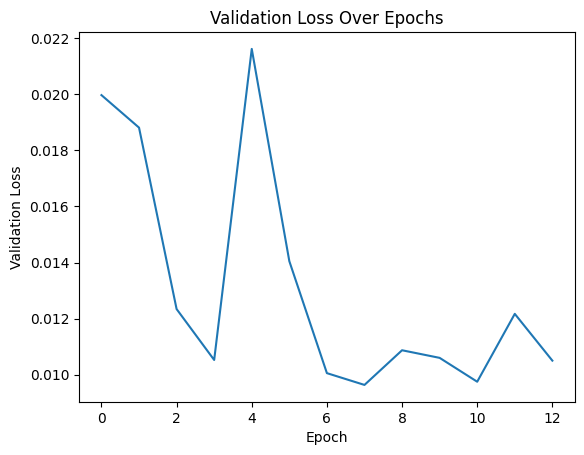

Training complete.
Best validation loss: 0.0096


In [5]:
model = CNN()

lr = 1e-3
criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=lr)

train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    epochs=40,
    patience=5,
    device=device
)

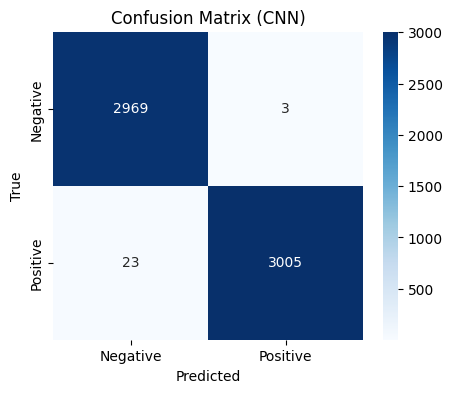

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      2972
         1.0       1.00      0.99      1.00      3028

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000



In [6]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from torch import nn
import numpy as np

model = CNN()
model.load_state_dict(torch.load("best_model.pth"))
model.to(device)
model.eval()

sigmoid = nn.Sigmoid()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)

        logits = model(images)
        probs = sigmoid(logits)

        preds = (probs > 0.5).long()

        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

all_preds = np.concatenate(all_preds).flatten()
all_labels = np.concatenate(all_labels).flatten()

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (CNN)")
plt.show()

print(classification_report(all_labels, all_preds))


# Evaluation

The model scored a robust ~99% accuracy, even though the classification report shows 100%? I have heard from a fellow student that some images was wrongly labeled so the accuracy maybe should be even higher. I implemented early stopping with a patience of 5 epochs, it was triggered at 12 epochs this last run.

